# Predicting gender from blog post

## Note to Preet: In this notebook I'm combining some categories and taking out "Industry Unknown". My f1 score is MUCH better when I do this. However, I'm not sure it's appropriate because I'm predicting 'gender' here and I'm not even adding 'topic' as a feature.

## Plot distribution of word counts
## Plotted ROC curve
## Need to plot most common words by category

In [40]:
import logging
logging.basicConfig(level=logging.WARNING)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
df = pd.read_csv('blogtext.csv', parse_dates = ['date']).sample(8000)

In [2]:
df = df[df['topic']!='indUnk'].copy()
# df = df[df['topic']!='Student'].copy()
df.reset_index(drop=True, inplace=True)
df.head()

,id,gender,age,topic,sign,date,text
0,2581469,female,23,Student,Pisces,"30,July,2004",urlLink the beginning of a box offi...
1,3441102,male,15,Student,Libra,"04,June,2004","Haven't blogged in a long time, and I'm..."
2,3298085,female,38,Technology,Capricorn,"05,August,2004",I called my Therapist and told her abou...
3,3666636,female,24,Advertising,Virgo,"17,June,2004",I have been inspired. I now have a blog...
4,3888550,female,25,Publishing,Sagittarius,"23,July,2004",Ahh despite not being hungove...


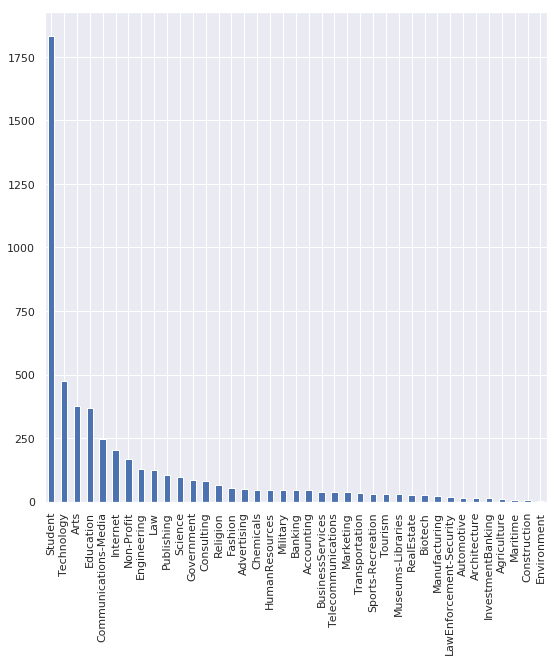

In [15]:
#Removing all classes but the 20 most populous.
# most_pop = list(df.groupby('topic')['topic'].agg('count').sort_values(ascending=False)[:20].index)
# df = df[df['topic'].isin(most_pop)]
# print(df.shape)
plt.figure(figsize=(9,9))
df['topic'].value_counts().plot('bar')
#A lot of these classes are super similar. I might need to combine them.

# Alright, time to combine a few categories

In [ ]:
# #First create a new column for edited categories
# TYPEDICT = {'Advertising':'Marketing', 'Internet':'Technology', 
#             'BusinessServices':'Consulting', 'Telecommunications':'Communications-Media', 
#             'Publishing':'Communications-Media', 'Government':'Law', 'Banking': 'Finance', 
#             'Accounting': 'Finance', 'Science': 'Science&Engineering', 'Engineering':'Science&Engineering'}
# df['custom_topic'] = df['topic'].map(lambda x: TYPEDICT[x] if x in TYPEDICT else x)

In [3]:
# df['custom_topic'].value_counts().plot('bar')
import spacy
import gensim
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import strip_short
from symspellpy import SymSpell, Verbosity
import pkg_resources
import re
nlp = spacy.load('en_core_web_sm')

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
stops = [spacy.lang.en.stop_words.STOP_WORDS] + stopwords.words('english')
def clean_jv(doc):
   typo_free = ' '.join([(sym_spell.lookup(i, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term) for i in doc])
   twol_free = strip_short(typo_free)
   return twol_free
def clean(lst):
    lst = [token for token in lst if not token.is_stop]
    lst = [token.lemma_ for token in lst if str(token.lemma_) not in stops]
    lst = [re.sub(r'[\W\d\s]', '', string) for string in lst]
    lst = [token for token in lst if token not in stops]
    while '' in lst:
        lst.remove('')
    lst = clean_jv(lst)
    return lst

In [4]:
df['tokens'] = df['text'].map(lambda x: nlp.tokenizer(x.lower()))
df['tokens'] = df['tokens'].map(lambda x: clean(x).split())
#Creating a single-string version of the cleaned texts, for tools that require it.
df['token_str'] = df['tokens'].map(lambda x: ' '.join(x))
doc_clean = df['tokens']
bigram =gensim.models.Phrases(doc_clean, min_count = 5, threshold = 50)
trigram =gensim.models.Phrases(bigram[doc_clean], min_count = 5, threshold = 50)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_trigrams(texts):
    return trigram_mod[bigram_mod[texts]]
doc_trigram = df['tokens'].map(lambda x: make_trigrams(x))
dct = gensim.corpora.Dictionary(doc_trigram)
dct.filter_extremes(no_below=5, no_above=0.6666, keep_n=90000)
doc_term_matrix = [dct.doc2bow(doc) for doc in doc_trigram]

In [91]:
df['length'] = df['text'].map(len)
df['tokenlen'] = df['tokens'].map(len)

In [17]:
#Taking a look at the results:
df['token_str'].loc[5041]
doc_term_matrix[0]
doc_trigram[9]

['lazy',
 'blog',
 'jeremy',
 'flick',
 'lip',
 'sit',
 'beni',
 'suppose',
 'take',
 'assignment',
 'bite',
 'good',
 'fuck',
 'knock',
 'keyboard',
 'say',
 'hello',
 'sushi',
 'today',
 'jeremy',
 'cry',
 'want',
 'blog',
 'bye']

# Do word counts by gender

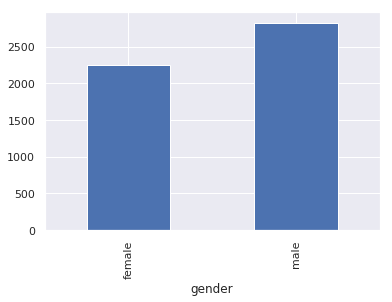

In [22]:
#Want to plot median word count by gender
df.groupby('gender')['tokens'].agg('count').plot('bar')
# plt.figure(figsize=(9,9))

In [32]:
# topics = list(df['custom_topic'].unique())
#find average length of the blogposts by class
def avlength(col):
    col.reset_index(drop=True,inplace=True)
    count = 0
    for i in range(1,len(col)):
        count += len(col[i])
    return count/(len(col))
avlength(df['tokens'])

88.07975580937376

In [93]:
male = df[df['gender']=='male']
female = df[df['gender']=='female']
male.shape
female.shape
df.shape
print(avlength(male['tokens']), avlength(female['tokens']))
#Male token lengths appear a bit longer.

87.84394904458598 88.34946714031972


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


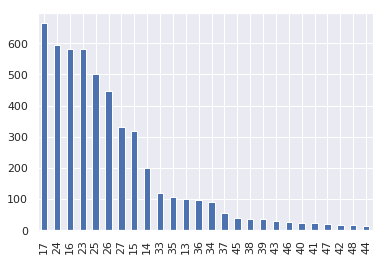

In [84]:
df.age.value_counts().plot('bar')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


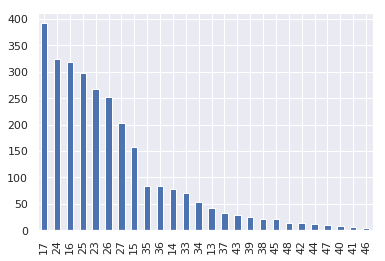

In [86]:
male.age.value_counts().plot('bar')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


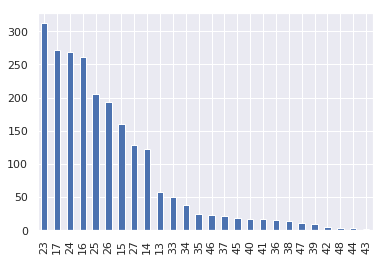

In [88]:
female.age.value_counts().plot('bar')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


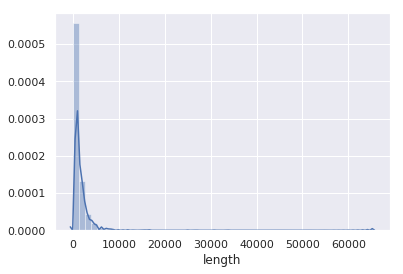

In [95]:
import seaborn as sns
sns.distplot(male['length'])

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


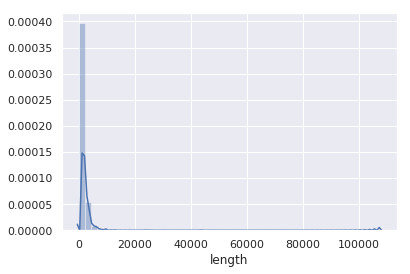

In [98]:
sns.distplot(female['length'])

In [101]:
from gensim.models import Word2Vec
males = [doc for doc in male['tokens']]
malemodel = Word2Vec(males, size=275, window=8, min_count=4, workers = 3)
females = [doc for doc in female['tokens']]
femalemodel = Word2Vec(females, size=275, window=8, min_count=4, workers = 3)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 21785 word types from a corpus of 248306 raw words and 2826 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=4 retains 7145 unique words (32% of original 21785, drops 14640)
INFO:gensim.models.word2vec:effective_min_count=4 leaves 227196 word corpus (91% of original 248306, drops 21110)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 21785 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 37 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 215628 word corpus (94.9% of prior 227196)
INFO:gensim.models.base_any2vec:estimated required memory for 7145 words and 275 dimensions: 19291500 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.base_any2vec:train

DEBUG:gensim.models.base_any2vec:worker exiting, processed 7 jobs
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 198968 raw words (168594 effective words) took 0.6s, 281939 effective words/s
DEBUG:gensim.models.base_any2vec:job loop exiting, total 21 jobs
DEBUG:gensim.models.base_any2vec:worker exiting, processed 7 jobs
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
DEBUG:gensim.models.base_any2vec:worker exiting, processed 8 jobs
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
DEBUG:gensim.models.base_any2vec:worker exiting, processed 6 jobs
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 5 : training on 198968 raw words (168636 effective words) took 0.6s, 285262 effective words/s
INFO:gensim.models.base_any2vec:training on

In [104]:
malewords = malemodel.wv.index2entity[:150]
femalewords = femalemodel.wv.index2entity[:150]
malewords

['like',
 'unlink',
 'time',
 'know',
 'think',
 'get',
 'day',
 'thing',
 'people',
 'good',
 'come',
 'say',
 'want',
 'work',
 'well',
 'look',
 'way',
 'year',
 'feel',
 'new',
 'today',
 'right',
 'love',
 'tell',
 'find',
 'start',
 'talk',
 'play',
 'try',
 'need',
 'friend',
 'long',
 'life',
 'see',
 'take',
 'night',
 'great',
 'read',
 'home',
 'little',
 'man',
 'leave',
 'yes',
 'lot',
 'let',
 'guy',
 'mean',
 'write',
 'end',
 'live',
 'post',
 'world',
 'late',
 'school',
 'week',
 'watch',
 'old',
 'blog',
 'ask',
 'make',
 'fun',
 'run',
 'happen',
 'place',
 'stuff',
 'pretty',
 'movie',
 'bad',
 'big',
 'give',
 'actually',
 'turn',
 'maybe',
 'away',
 'sure',
 'hour',
 'girl',
 'call',
 'game',
 'okay',
 'help',
 'person',
 'hear',
 'head',
 'god',
 'sit',
 'nice',
 'point',
 'book',
 'bite',
 'interest',
 'reason',
 'hope',
 'tbsp',
 'guess',
 'walk',
 'change',
 'word',
 'wrong',
 'hard',
 'mind',
 'stop',
 'low',
 'house',
 'song',
 'hand',
 'decide',
 'state',


In [105]:
femalewords

['like',
 'know',
 'think',
 'get',
 'time',
 'day',
 'want',
 'thing',
 'come',
 'love',
 'unlink',
 'good',
 'people',
 'feel',
 'say',
 'look',
 'work',
 'today',
 'tell',
 'way',
 'friend',
 'well',
 'need',
 'life',
 'right',
 'find',
 'year',
 'new',
 'try',
 'night',
 'leave',
 'little',
 'yes',
 'talk',
 'home',
 'see',
 'start',
 'long',
 'take',
 'man',
 'mean',
 'week',
 'lot',
 'let',
 'read',
 'ask',
 'watch',
 'guy',
 'write',
 'school',
 'great',
 'play',
 'end',
 'fun',
 'okay',
 'hope',
 'live',
 'house',
 'late',
 'girl',
 'god',
 'nice',
 'walk',
 'make',
 'happen',
 'place',
 'guess',
 'old',
 'bad',
 'call',
 'away',
 'world',
 'sit',
 'actually',
 'give',
 'maybe',
 'mon',
 'post',
 'movie',
 'pretty',
 'run',
 'stuff',
 'hour',
 'sleep',
 'head',
 'hear',
 'eat',
 'sure',
 'low',
 'wait',
 'happy',
 'big',
 'help',
 'blog',
 'wrong',
 'miss',
 'word',
 'turn',
 'person',
 'book',
 'morning',
 'change',
 'tbsp',
 'cut',
 'bite',
 'hard',
 'break',
 'meet',
 'lose'

In [106]:
#Most frequent male words that don't appear in female posts
[word for word in malewords if word not in femalewords]

['game',
 'interest',
 'reason',
 'state',
 'high',
 'party',
 'far',
 'bring',
 'the',
 'win',
 'music',
 'war',
 'question',
 'course',
 'fall',
 'story',
 'site',
 'bush',
 'idea',
 'open',
 'problem',
 'check',
 'different']

In [111]:
#Most frequent female words that don't appear in male posts
[word for word in femalewords if word not in malewords]

['mon',
 'miss',
 'cut',
 'eye',
 'room',
 'drink',
 'thank',
 'care',
 'hate',
 'woman',
 'job',
 'wish',
 'family',
 'heart',
 'weekend',
 'soon',
 'finally',
 'close',
 'month',
 'hair',
 'stay',
 'wonder',
 'yesterday']